# Кольцевое бета-распределение каршеринговых машин по Москве + заправки + экспорт датасета

Этот ноутбук:

1. Генерирует гладкое двумерное распределение каршеринговых машин вокруг центра Москвы
   с помощью бета-распределения по радиусу.
2. Назначает каждой машине уровень заправленности бака по заданному распределению:
   - < 10% бака — 1% парка
   - 10–20% — 3% парка
   - 20–50% — 20% парка
   - остальные машины считаются «заправленными» (> 50%).
3. Загружает датасет с координатами заправок.
4. Удаляет дубликаты заправок по координатам и оставляет только АЗС,
   находящиеся не дальше чем на 5 км от МКАД.
5. Визуализирует одновременно машины и заправки на карте Москвы.
6. Формирует датасеты машин (координаты + уровень заправленности) и сохраняет их в CSV.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# -----------------------
# Конфигурация модели
# -----------------------

CONFIG = {
    "city": "Moscow",
    "random_seed": 42,
    # Центр Москвы (примерно Кремль)
    "city_center": {"lat": 55.7558, "lon": 37.6176},
    # Радиусы основных колец (км)
    "rings_km": {
        "sadovoe": 2.2,
        "ttk": 5.0,
        "mkad": 16.5,
    },
    # Минимальный радиус, внутри которого машин почти нет (запрет парковки)
    "min_radius_km": 1.0,
    # Максимальный радиус, до которого моделируем город (чуть дальше МКАД)
    "max_radius_km": 20.0,
    # Объем бака машины (л)
    "tank_volume_l": 50,
    # Варианты размеров парка
    "fleet_sizes": [2000, 5000, 10000],
    # Распределение уровня заправленности (доля бака)
    # Вероятности задаются через поле share.
    "fuel_level_distribution": [
        {"range": [0.0, 0.1], "share": 0.01},  # < 10% бака — 1% парка
        {"range": [0.1, 0.2], "share": 0.03},  # 10–20% — 3% парка
        {"range": [0.2, 0.5], "share": 0.20},  # 20–50% — 20% парка
        # Остальные (1 - сумма share) будут иметь уровень [0.5, 1.0]
    ],
    # Радиальное распределение по времени суток (бета-распределение)
    "radial_beta_scenarios": {
        "morning": {
            # Пик между Садовым и ТТК, небольшой хвост к МКАД
            "alpha": 2.1,
            "beta": 4.0,
        },
        "evening": {
            # Более широкое распределение, больше массы ближе к МКАД
            "alpha": 5.0,
            "beta": 2.0,
        },
    },
}

np.random.seed(CONFIG["random_seed"])

In [ ]:
from math import radians, sqrt

# ---- Вспомогательные функции для координат ----

def km_to_deg_lat(km: float) -> float:
    """Перевод километров в градусы широты (приблизительно)."""
    return km / 111.0

def km_to_deg_lon(km: float, lat_deg: float) -> float:
    """Перевод километров в градусы долготы (приблизительно)."""
    return km / (111.0 * np.cos(np.radians(lat_deg)))

def deg_to_km(center_lat, center_lon, lat, lon):
    """Грубая оценка расстояния в км от центра до точки (lat, lon)
    в проекции на плоскость. Используем манхэттенскую метрику по осям (N-S, E-W)."""
    dlat_km = (lat - center_lat) * 111.0
    dlon_km = (lon - center_lon) * 111.0 * np.cos(np.radians(center_lat))
    return np.abs(dlat_km) + np.abs(dlon_km)

# ---- Радиальное бета-распределение ----


def sample_radii_beta(n_points, scenario_cfg, min_radius_km, max_radius_km):
    """Генерация радиусов r (км) из бета-распределения на [min_radius_km, max_radius_km]."""
    alpha = scenario_cfg["alpha"]
    beta = scenario_cfg["beta"]
    x = np.random.beta(alpha, beta, size=n_points)  # на [0, 1]
    r = min_radius_km + x * (max_radius_km - min_radius_km)
    return r

def sample_positions_beta_ring(center_lat, center_lon, n_points, scenario_name, config=CONFIG):
    """Генерируем точки:
    1. Сэмплим радиус r по бета-распределению.
    2. Сэмплим угол θ ~ U(0, 2π).
    3. Переводим (r, θ) в lat/lon.
    """
    scenario_cfg = config["radial_beta_scenarios"][scenario_name]
    min_r = config["min_radius_km"]
    max_r = config["max_radius_km"]

    # Радиусы и углы
    r_km = sample_radii_beta(n_points, scenario_cfg, min_r, max_r)
    theta = np.random.uniform(0.0, 2.0 * np.pi, size=n_points)

    # Декартовы смещения в км
    x_km = r_km * np.cos(theta)
    y_km = r_km * np.sin(theta)

    # Перевод в градусы
    lat_offsets_deg = km_to_deg_lat(y_km)
    lon_offsets_deg = km_to_deg_lon(x_km, center_lat)

    lats = center_lat + lat_offsets_deg
    lons = center_lon + lon_offsets_deg
    return lats, lons, r_km

def generate_positions(n_cars, scenario_name, config=CONFIG):
    """Позиции машин: бета-распределение по радиусу + равномерный угол."""
    center = config["city_center"]
    lats, lons, r_km = sample_positions_beta_ring(center["lat"], center["lon"], n_cars, scenario_name, config)
    return lats, lons, r_km

# ---- Уровни топлива ----

def generate_fuel_levels(n_cars, config=CONFIG):
    """Генерация уровня топлива (доля бака) и требуемого долива (л).

    Распределение:
    - < 10% бака — 1% парка
    - 10–20%     — 3% парка
    - 20–50%     — 20% парка
    - остальное  — [0.5, 1.0]
    """
    dist = config["fuel_level_distribution"]
    tank_volume = config["tank_volume_l"]

    shares = [item["share"] for item in dist]
    ranges = [item["range"] for item in dist]
    thresholds = np.cumsum(shares)

    fuel_levels = np.empty(n_cars)
    u = np.random.rand(n_cars)

    for i in range(n_cars):
        x = u[i]
        if x < thresholds[0]:
            low, high = ranges[0]
        elif x < thresholds[1]:
            low, high = ranges[1]
        elif x < thresholds[2]:
            low, high = ranges[2]
        else:
            low, high = 0.5, 1.0
        fuel_levels[i] = np.random.uniform(low, high)

    needed_liters = (1.0 - fuel_levels) * tank_volume
    need_refuel = fuel_levels < 0.5
    return fuel_levels, needed_liters, need_refuel

def simulate_fleet(n_cars, scenario_name, config=CONFIG):
    """Полная симуляция: позиции + топливо."""
    lats, lons, r_km = generate_positions(n_cars, scenario_name, config)
    fuel_levels, needed_liters, need_refuel = generate_fuel_levels(n_cars, config)

    df = pd.DataFrame({
        "car_id": np.arange(n_cars),
        "time_of_day": scenario_name,
        "lat": lats,
        "lon": lons,
        "radius_km": r_km,
        "fuel_level": fuel_levels,
        "needed_liters": needed_liters,
        "need_refuel": need_refuel,
    })
    return df

# ---- Окружности и карты ----

def circle_points(center_lat, center_lon, radius_km, num_points=360):
    """Координаты окружности радиуса radius_km вокруг центра."""
    angles = np.linspace(0, 2 * np.pi, num_points)
    x_km = radius_km * np.cos(angles)
    y_km = radius_km * np.sin(angles)

    lat_offsets_deg = km_to_deg_lat(y_km)
    lon_offsets_deg = km_to_deg_lon(x_km, center_lat)

    lats = center_lat + lat_offsets_deg
    lons = center_lon + lon_offsets_deg
    return lats, lons

def plot_map_with_rings_and_stations(df_cars, df_stations, title, config=CONFIG):
    """Карта с машинами, заправками и кольцами."""
    center = config["city_center"]
    rings = config["rings_km"]

    plt.figure(figsize=(6, 6))
    # Заправки
    plt.scatter(df_stations["lon"], df_stations["lat"], s=12, alpha=0.8, marker="^", label="АЗС")
    # Машины
    plt.scatter(df_cars["lon"], df_cars["lat"], s=3, alpha=0.3, label="Машины")

    sad_lats, sad_lons = circle_points(center["lat"], center["lon"], rings["sadovoe"])
    ttk_lats, ttk_lons = circle_points(center["lat"], center["lon"], rings["ttk"])
    mkad_lats, mkad_lons = circle_points(center["lat"], center["lon"], rings["mkad"])

    plt.plot(sad_lons, sad_lats, linewidth=1.5, label="Садовое кольцо")
    plt.plot(ttk_lons, ttk_lats, linewidth=1.5, label="ТТК")
    plt.plot(mkad_lons, mkad_lats, linewidth=1.5, label="МКАД")

    plt.scatter([center["lon"]], [center["lat"]], marker="x", s=80, label="Центр города")

    plt.xlabel("Долгота")
    plt.ylabel("Широта")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

def plot_fuel_histogram(df, title):
    """Гистограмма распределения уровня топлива."""
    plt.figure(figsize=(6, 4))
    plt.hist(df["fuel_level"], bins=20)
    plt.xlabel("Уровень топлива (доля бака)")
    plt.ylabel("Количество машин")
    plt.title(title)
    plt.grid(True)
    plt.show()

def print_ring_stats(df, config=CONFIG):
    """Доля машин в диапазонах: до Садового, между Садовым и ТТК, между ТТК и МКАД, за МКАД."""
    rings = config["rings_km"]
    r = df["radius_km"].values

    sad = rings["sadovoe"]
    ttk = rings["ttk"]
    mkad = rings["mkad"]

    inner = r < sad
    sad_ttk = (r >= sad) & (r < ttk)
    ttk_mkad = (r >= ttk) & (r < mkad)
    outside = r >= mkad

    n = len(r)
    print(f"Всего машин: {n}")
    print(f"  Внутри Садового (< {sad} км): {inner.mean():.3f}")
    print(f"  Между Садовым и ТТК ([{sad}, {ttk}) км): {sad_ttk.mean():.3f}")
    print(f"  Между ТТК и МКАД ([{ttk}, {mkad}) км): {ttk_mkad.mean():.3f}")
    print(f"  За МКАД (>= {mkad} км): {outside.mean():.3f}")

In [ ]:
# Загрузка датасета с заправками и фильтрация по расстоянию от МКАД

stations_csv_path = "moscow_stations.csv"  # путь поправь под себя, если нужно

df_stations_raw = pd.read_csv(stations_csv_path)
print("Всего записей в датасете заправок:", len(df_stations_raw))
print(df_stations_raw.head())

# Убираем дубликаты по координатам
df_stations = df_stations_raw.drop_duplicates(subset=["lat", "lon"]).copy()
print("Уникальных заправок по координатам до фильтрации:", len(df_stations))

# Радиус от центра для каждой заправки
center_lat = CONFIG["city_center"]["lat"]
center_lon = CONFIG["city_center"]["lon"]
mkad_r = CONFIG["rings_km"]["mkad"]
buffer_km = 5.0  # не дальше чем 5 км от МКАД

df_stations["radius_km"] = deg_to_km(center_lat, center_lon,
                                     df_stations["lat"].values,
                                     df_stations["lon"].values)

mask = df_stations["radius_km"] <= mkad_r + buffer_km
df_stations = df_stations[mask].copy()

print("АЗС после фильтрации (<= МКАД + 5 км):", len(df_stations))

Всего записей в датасете заправок: 1359
         lat        lon  price
0  54.936169  37.530037  60.01
1  55.886448  38.169321  67.80
2  54.936610  37.527840  60.01
3  55.875330  38.199880  60.34
4  55.450078  37.527992  59.90
Уникальных заправок по координатам до фильтрации: 1313
АЗС после фильтрации (<= МКАД + 5 км): 367


Симуляция для парка из 5000 машин

=== Утро ===
Всего машин: 5000
  Внутри Садового (< 2.2 км): 0.026
  Между Садовым и ТТК ([2.2, 5.0) км): 0.223
  Между ТТК и МКАД ([5.0, 16.5) км): 0.746
  За МКАД (>= 16.5 км): 0.006


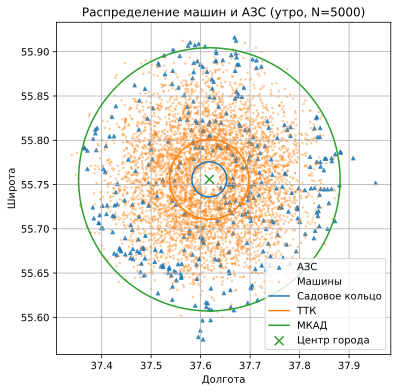

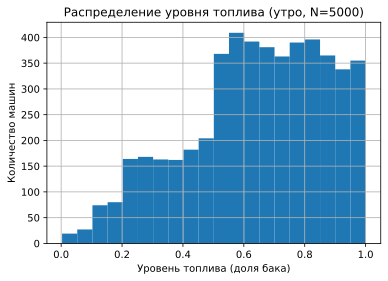


=== Вечер ===
Всего машин: 5000
  Внутри Садового (< 2.2 км): 0.000
  Между Садовым и ТТК ([2.2, 5.0) км): 0.002
  Между ТТК и МКАД ([5.0, 16.5) км): 0.682
  За МКАД (>= 16.5 км): 0.316


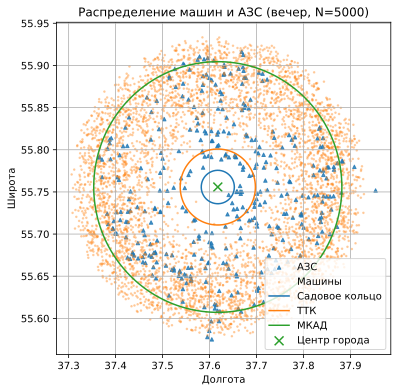

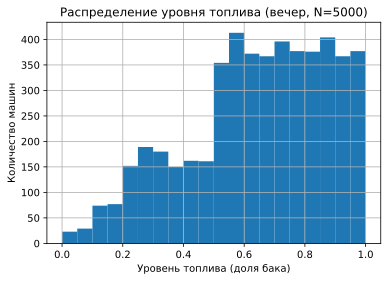

In [ ]:
# Пример: парк 10 000 машин, утро и вечер + отфильтрованные заправки

fleet_size = CONFIG["fleet_sizes"][1]  # 10 000
print(f"Симуляция для парка из {fleet_size} машин")

df_morning = simulate_fleet(fleet_size, "morning", CONFIG)
df_evening = simulate_fleet(fleet_size, "evening", CONFIG)

print("\n=== Утро ===")
print_ring_stats(df_morning, CONFIG)
plot_map_with_rings_and_stations(df_morning, df_stations,
                                 f"Распределение машин и АЗС (утро, N={fleet_size})", CONFIG)
plot_fuel_histogram(df_morning, f"Распределение уровня топлива (утро, N={fleet_size})")

print("\n=== Вечер ===")
print_ring_stats(df_evening, CONFIG)
plot_map_with_rings_and_stations(df_evening, df_stations,
                                 f"Распределение машин и АЗС (вечер, N={fleet_size})", CONFIG)
plot_fuel_histogram(df_evening, f"Распределение уровня топлива (вечер, N={fleet_size})")

In [ ]:
# Сохранение датасетов машин (координаты + уровень заправленности) в CSV

# Можно переопределить fleet_size выше и заново пересимулировать парк,
# тогда здесь просто сохраняем актуальные df_morning и df_evening.

cols = ["car_id", "time_of_day", "lat", "lon", "fuel_level", "needed_liters", "need_refuel"]

output_morning = "cars_morning_{}k.csv".format(fleet_size // 1000)
output_evening = "cars_evening_{}k.csv".format(fleet_size // 1000)

df_morning[cols].to_csv(output_morning, index=False)
df_evening[cols].to_csv(output_evening, index=False)

print("Сохранён файл с утренним парком:", output_morning)
print("Сохранён файл с вечерним парком:", output_evening)

Сохранён файл с утренним парком: cars_morning_5k.csv
Сохранён файл с вечерним парком: cars_evening_5k.csv



## Кластеризация машин и выбор оптимальной заправки для каждого кластера

Ниже реализован простой алгоритм:

1. Берём машины, которые нуждаются в дозаправке (столбец `need_refuel == True`).
2. Кластеризуем их по координатам при помощи `KMeans` так, чтобы средний размер кластера был около 5–6 машин.
3. Для каждого кластера считаем:
   * центр кластера (среднее по широте и долготе),
   * суммарную потребность в топливе `sum(D)` по столбцу `needed_liters`,
   * стоимость обслуживания кластера от каждой заправки:

      \[
      \text{cost}_{c,s} = P_s \cdot \sum_{j \in c} D_j \, + \, C_{dist} \cdot d(c, s),
      \]

      где `P_s` — цена топлива на станции, `C_dist` — стоимость 1 км пробега бензовоза,  
      `d(c, s)` — расстояние от центра кластера до заправки в километрах.
4. Каждому кластеру сопоставляем заправку с минимальной стоимостью `cost_{c,s}`.
5. Визуализируем кластеры, их центры и выбранные для них заправки.


Всего машин в парке: 5000, из них нужно заправить: 1228
Число кластеров K = 205
Размеры кластеров (cluster_id -> #машин):
cluster_id
0     10
1     10
2      7
3      7
4      5
5      6
6      4
7      4
8      8
9      2
10     7
11    11
12     6
13     7
14     4
15     3
16     6
17    10
18     4
19     3
Name: count, dtype: int64

Первые несколько кластеров и их выбранные заправки:
   cluster_id  center_lat  center_lon  n_cars  sum_needed_liters  \
0           0   55.751396   37.520714      10         309.719350   
1           1   55.762705   37.648818      10         325.769873   
2           2   55.726294   37.758884       7         237.805472   
3           3   55.684516   37.577660       7         255.694811   
4           4   55.822267   37.789988       5         174.374189   

   best_station_idx  best_station_price  best_station_dist_km  best_total_cost  
0               202               60.69              0.592130     19191.225875  
1              1328               59.

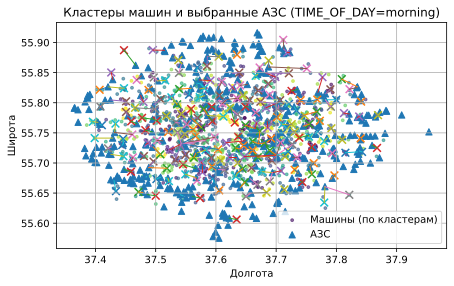

In [ ]:

from sklearn.cluster import KMeans

# -------------------------
# Параметры кластеризации
# -------------------------

TIME_OF_DAY = "morning"      # можно переключить на "evening"
TARGET_CLUSTER_SIZE = 6      # хотим ~5–6 машин в кластере
C_DIST_PER_KM = 666.0         # руб/км пробега бензовоза

# Выбираем парк для заданного времени суток
if TIME_OF_DAY == "morning":
    df_cars_full = df_morning.copy()
elif TIME_OF_DAY == "evening":
    df_cars_full = df_evening.copy()
else:
    raise ValueError("TIME_OF_DAY должно быть 'morning' или 'evening'")

# Берём только машины, которые реально нужно заправлять
df_cars = df_cars_full[df_cars_full["need_refuel"]].reset_index(drop=True)
print(f"Всего машин в парке: {len(df_cars_full)}, из них нужно заправить: {len(df_cars)}")

if len(df_cars) == 0:
    raise RuntimeError("Нет машин с need_refuel == True. Проверь генерацию данных.")

# -------------------------
# KMeans-кластеризация машин
# -------------------------

n_cars = len(df_cars)
n_clusters = max(1, round(n_cars / TARGET_CLUSTER_SIZE))
print(f"Число кластеров K = {n_clusters}")

X = df_cars[["lat", "lon"]].to_numpy()

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=CONFIG["random_seed"],
    n_init=10,
)
df_cars["cluster_id"] = kmeans.fit_predict(X)
cluster_centers = kmeans.cluster_centers_

# Немного статистики по размерам кластеров
cluster_sizes = df_cars["cluster_id"].value_counts().sort_index()
print("Размеры кластеров (cluster_id -> #машин):")
print(cluster_sizes.head(20))

# -------------------------
# Стоимость кластера для заправок
# -------------------------

cluster_records = []

for cid in sorted(df_cars["cluster_id"].unique()):
    cars_c = df_cars[df_cars["cluster_id"] == cid]
    n_in_cluster = len(cars_c)
    sum_needed = cars_c["needed_liters"].sum()

    center_lat, center_lon = cluster_centers[cid]

    best_cost = None
    best_station_idx = None
    best_dist_km = None

    for st_idx, st_row in df_stations.iterrows():
        d_km = deg_to_km(center_lat, center_lon, st_row["lat"], st_row["lon"])
        fuel_cost = st_row["price"] * sum_needed
        dist_cost = C_DIST_PER_KM * d_km
        total_cost = fuel_cost + dist_cost

        if (best_cost is None) or (total_cost < best_cost):
            best_cost = total_cost
            best_station_idx = st_idx
            best_dist_km = d_km

    cluster_records.append({
        "cluster_id": cid,
        "center_lat": center_lat,
        "center_lon": center_lon,
        "n_cars": n_in_cluster,
        "sum_needed_liters": sum_needed,
        "best_station_idx": best_station_idx,
        "best_station_price": df_stations.loc[best_station_idx, "price"],
        "best_station_dist_km": best_dist_km,
        "best_total_cost": best_cost,
    })

df_clusters = pd.DataFrame(cluster_records)
print("\nПервые несколько кластеров и их выбранные заправки:")
print(df_clusters.head())

# -------------------------
# Визуализация кластеров и выбранных заправок
# -------------------------

plt.figure(figsize=(7, 7))

# Машины, раскрашенные по cluster_id
plt.scatter(
    df_cars["lon"],
    df_cars["lat"],
    s=8,
    c=df_cars["cluster_id"],
    alpha=0.6,
    label="Машины (по кластерам)",
)

# Станции
plt.scatter(
    df_stations["lon"],
    df_stations["lat"],
    s=40,
    marker="^",
    label="АЗС",
)

# Центры кластеров и линии до выбранной АЗС
for _, row in df_clusters.iterrows():
    cid = row["cluster_id"]
    cl_lon, cl_lat = row["center_lon"], row["center_lat"]
    st = df_stations.loc[row["best_station_idx"]]

    # центр кластера
    plt.scatter([cl_lon], [cl_lat], s=60, marker="x")

    # линия от центра кластера до заправки
    plt.plot(
        [cl_lon, st["lon"]],
        [cl_lat, st["lat"]],
        linewidth=1.0,
    )

plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.title(f"Кластеры машин и выбранные АЗС (TIME_OF_DAY={TIME_OF_DAY})")
plt.legend(loc="best")
plt.grid(True)
plt.gca().set_aspect("equal", "box")
plt.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# --- аккуратный station_id для станций ---
df_st_plot = df_stations.copy()
if "station_id" not in df_st_plot.columns:
    df_st_plot = df_st_plot.reset_index().rename(columns={"index": "station_id"})

# --- базовый scatter по машинам (цвет = кластер) ---
cars_for_plot = df_cars.copy()

fig = px.scatter(
    cars_for_plot,
    x="lon",
    y="lat",
    color="cluster_id",
    hover_data=["car_id", "cluster_id", "needed_liters"],
    title=f"Кластеры машин и выбранные АЗС (TIME_OF_DAY={TIME_OF_DAY})",
    labels={"lon": "Долгота", "lat": "Широта", "cluster_id": "Кластер"},
)

# сделаем точки машин поменьше и полупрозрачными
fig.update_traces(
    selector=dict(mode="markers"),
    marker=dict(size=5, opacity=0.7),
    showlegend=False,  # легенда по кластерам обычно перегружает
)

# --- АЗС: треугольнички с подписями station_id ---
fig.add_trace(
    go.Scatter(
        x=df_st_plot["lon"],
        y=df_st_plot["lat"],
        mode="markers+text",
        text=df_st_plot["station_id"],
        textposition="top center",
        marker=dict(symbol="triangle-up", size=11, line=dict(width=1)),
        name="АЗС",
        hovertemplate=(
            "АЗС %{text}<br>"
            "Цена: %{customdata[0]:.2f} руб/л<br>"
            "lon: %{x:.5f}<br>lat: %{y:.5f}<extra></extra>"
        ),
        customdata=df_st_plot[["price"]].to_numpy(),
    )
)

# --- центры кластеров: крестики с номером кластера ---
fig.add_trace(
    go.Scatter(
        x=df_clusters["center_lon"],
        y=df_clusters["center_lat"],
        mode="markers+text",
        text=df_clusters["cluster_id"],
        textposition="bottom center",
        marker=dict(symbol="x", size=10),
        name="Центры кластеров",
        hovertemplate=(
            "Кластер %{text}<br>"
            "Σ потребность: %{customdata[0]:.1f} л<br>"
            "lon: %{x:.5f}<br>lat: %{y:.5f}<extra></extra>"
        ),
        customdata=df_clusters[["sum_needed_liters"]].to_numpy()
        if "sum_needed_liters" in df_clusters.columns
        else None,
    )
)

# --- линии от центра кластера до выбранной АЗС (путь бензовоза от АЗС к кластеру) ---

clusters_with_st = df_clusters.merge(
    df_st_plot[["station_id", "lat", "lon"]],
    left_on="best_station_idx",
    right_on="station_id",
    how="left",
    suffixes=("_cluster", "_station"),
)

for _, row in clusters_with_st.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row["center_lon"], row["lon"]],
            y=[row["center_lat"], row["lat"]],
            mode="lines",
            line=dict(width=1),
            showlegend=False,
            hoverinfo="skip",
        )
    )

# --- оформление: карта, зум, легенда ---
fig.update_layout(
    xaxis_title="longitude",
    yaxis_title="latitude",
    yaxis_scaleanchor="x",  # одинаковый масштаб осей => геометрия не искажается
    hovermode="closest",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0,
    ),
    width=1000,
    height=700,
)

fig.show()


## Подсчёт метрики TotalCost

TotalCost — это суммарная стоимость топлива и пробега для всех кластеров, если каждый кластер обслуживается "своей" выбранной АЗС.

In [ ]:
# Подсчёт итоговой метрики TotalCost для текущей конфигурации кластеров и АЗС.

if "df_clusters" not in globals():
    raise RuntimeError(
        "Сначала запусти ячейку с кластеризацией и выбором заправок (там создаётся df_clusters)."
    )

# 1. Суммарная стоимость по кластерам (топливо + пробег)
total_cost = df_clusters["best_total_cost"].sum()

# 2. Разложим на компоненты для наглядности
total_fuel_cost = (df_clusters["best_station_price"] * df_clusters["sum_needed_liters"]).sum()
total_distance_cost = C_DIST_PER_KM * df_clusters["best_station_dist_km"].sum()

print(f"Общая стоимость топлива (FuelCost): {total_fuel_cost:,.2f} руб")
print(f"Общая стоимость пробега (DistanceCost): {total_distance_cost:,.2f} руб")
print(f"Итоговая метрика TotalCost: {total_cost:,.2f} руб")

# 3. Вспомогательные агрегаты
n_clusters = len(df_clusters)
try:
    n_cars_refuel = len(df_cars)
except NameError:
    n_cars_refuel = None

print("\nКластеров:", n_clusters)
if n_cars_refuel is not None:
    print("Машин к заправке:", n_cars_refuel)
    print(f"Средний TotalCost на кластер: {total_cost / n_clusters:,.2f} руб")
    print(f"Средний TotalCost на машину: {total_cost / n_cars_refuel:,.2f} руб")


Общая стоимость топлива (FuelCost): 2,511,554.36 руб
Общая стоимость пробега (DistanceCost): 174,505.53 руб
Итоговая метрика TotalCost: 2,686,059.89 руб

Кластеров: 205
Машин к заправке: 1228
Средний TotalCost на кластер: 13,102.73 руб
Средний TotalCost на машину: 2,187.35 руб


In [ ]:
C_DIST_PER_KM_METRIC = 22.75


# ===============================================
# Обновлённый расчёт стоимости для кластеров
# Маршрут: АЗС -> ближайшая машина -> объезд всех -> АЗС
# ===============================================

import numpy as np

def compute_cluster_route_km(cars_c: pd.DataFrame, station_lat: float, station_lon: float) -> float:
    """
    Возвращает длину маршрута бензовоза (км) для ОДНОГО кластера и ОДНОЙ АЗС:
    АЗС -> ближайшая машина -> остальные машины (жадно по ближайшей) -> АЗС.
    cars_c: подтаблица df_cars для одного cluster_id (нужны столбцы lat, lon).
    """
    n = len(cars_c)
    if n == 0:
        return 0.0

    # Координаты всех машин кластера
    coords = cars_c[["lat", "lon"]].to_numpy()

    # 1. Находим машину, ближайшую к АЗС
    dist_from_station = np.array([
        deg_to_km(station_lat, station_lon, lat, lon)
        for (lat, lon) in coords
    ])
    start_idx = int(dist_from_station.argmin())

    visited = np.zeros(n, dtype=bool)
    visited[start_idx] = True
    order = [start_idx]
    current_idx = start_idx

    total_km = 0.0

    # АЗС -> первая (ближайшая) машина
    first_lat, first_lon = coords[start_idx]
    total_km += deg_to_km(station_lat, station_lon, first_lat, first_lon)

    # 2. Объезд остальных машин жадным "ближайшим соседом"
    while len(order) < n:
        cur_lat, cur_lon = coords[current_idx]

        best_j = None
        best_d = None
        for j in range(n):
            if visited[j]:
                continue
            lat_j, lon_j = coords[j]
            d = deg_to_km(cur_lat, cur_lon, lat_j, lon_j)
            if (best_d is None) or (d < best_d):
                best_d = d
                best_j = j

        visited[best_j] = True
        order.append(best_j)
        current_idx = best_j
        total_km += best_d

    # 3. Последняя машина -> АЗС
    last_lat, last_lon = coords[order[-1]]
    total_km += deg_to_km(last_lat, last_lon, station_lat, station_lon)

    return float(total_km)


# -----------------------------------------------
# Пересчёт df_clusters с новым методом стоимости
# -----------------------------------------------

cluster_records = []

for cid in sorted(df_cars["cluster_id"].unique()):
    cars_c = df_cars[df_cars["cluster_id"] == cid]
    n_in_cluster = len(cars_c)
    sum_needed = cars_c["needed_liters"].sum()

    center_lat, center_lon = cluster_centers[cid]

    best_cost = None
    best_station_idx = None
    best_route_km = None  # длина полного обхода кластера

    for st_idx, st_row in df_stations.iterrows():
        # Полный маршрут: АЗС -> кластер (обход всех машин) -> АЗС
        route_km = compute_cluster_route_km(
            cars_c,
            station_lat=st_row["lat"],
            station_lon=st_row["lon"],
        )

        fuel_cost = st_row["price"] * sum_needed
        dist_cost = C_DIST_PER_KM * route_km
        total_cost = fuel_cost + dist_cost

        if (best_cost is None) or (total_cost < best_cost):
            best_cost = total_cost
            best_station_idx = st_idx
            best_route_km = route_km

    cluster_records.append({
        "cluster_id": cid,
        "center_lat": center_lat,
        "center_lon": center_lon,
        "n_cars": n_in_cluster,
        "sum_needed_liters": sum_needed,
        "best_station_idx": best_station_idx,
        "best_station_price": df_stations.loc[best_station_idx, "price"],
        "best_route_km": best_route_km,   # вместо расстояния до центра
        "best_total_cost": best_cost,
    })

df_clusters = pd.DataFrame(cluster_records)

print("\nПервые несколько кластеров и их выбранные заправки (обновлённый расчёт):")
print(df_clusters.head())

# -----------------------------------------------
# Пересчёт total_cost с учётом нового маршрута
# -----------------------------------------------

total_cost = df_clusters["best_total_cost"].sum()

total_fuel_cost = (df_clusters["best_station_price"] * df_clusters["sum_needed_liters"]).sum()
total_distance_cost = C_DIST_PER_KM_METRIC * df_clusters["best_route_km"].sum()

print("\n============================")
print("ИТОГИ С НОВОЙ МЕТРИКОЙ")
print(f"Общая стоимость:          {total_cost:,.2f}")
print(f"  — топливо:             {total_fuel_cost:,.2f}")
print(f"  — пробег (км * тариф): {total_distance_cost:,.2f}")
print("============================")



Первые несколько кластеров и их выбранные заправки (обновлённый расчёт):
   cluster_id  center_lat  center_lon  n_cars  sum_needed_liters  \
0           0   55.751396   37.520714      10         309.719350   
1           1   55.762705   37.648818      10         325.769873   
2           2   55.726294   37.758884       7         237.805472   
3           3   55.684516   37.577660       7         255.694811   
4           4   55.822267   37.789988       5         174.374189   

   best_station_idx  best_station_price  best_route_km  best_total_cost  
0               202               60.69       8.898918     24723.546546  
1               701               60.95       9.507305     26187.538843  
2               918               60.75       5.637653     18201.359220  
3               466               61.45       6.370754     19955.367984  
4              1327               61.35       4.996378     14025.444189  

ИТОГИ С НОВОЙ МЕТРИКОЙ
Общая стоимость:          3,339,725.56
  — топлив

In [ ]:

# ===============================================
# Стоимость простоя машин (9 руб/мин) как в baseline_4
# Добавляем кластерам idle-cost на основе маршрута бензовоза
# ===============================================

import numpy as np

# Средняя скорость бензовоза по городу, км/ч (как в baseline_4)
AVERAGE_TANKER_SPEED_KMPH = 30.0

# Стоимость простоя, руб/мин (если машина ещё не заправлена)
WAIT_COST_RUB_PER_MIN = 9.0

# Моя штука
C_DIST_PER_KM_METRIC = 22.75


def compute_cluster_route_and_idle_cost(
    cars_c: pd.DataFrame,
    station_lat: float,
    station_lon: float,
    avg_speed_kmph: float = AVERAGE_TANKER_SPEED_KMPH,
    idle_cost_per_min: float = WAIT_COST_RUB_PER_MIN,
):
    """
    Возвращает (длина_маршрута_км, стоимость_простоя_руб) для ОДНОГО кластера и ОДНОЙ АЗС.

    Маршрут:
        АЗС -> ближайшая машина -> остальные машины (жадно по ближайшей) -> АЗС.

    Стоимость простоя считается только для машин, которые нуждаются в заправке:
    - если есть колонка 'need_refuel', берём по ней;
    - иначе, если есть 'needed_liters', считаем, что нуждаются те, у кого needed_liters > 0;
    - иначе считаем, что все машины в кластере ждут заправки.
    """
    n = len(cars_c)
    if n == 0:
        return 0.0, 0.0

    coords = cars_c[["lat", "lon"]].to_numpy()

    # Маска нуждающихся в заправке машин
    if "need_refuel" in cars_c.columns:
        needs_refuel = cars_c["need_refuel"].to_numpy().astype(bool)
    elif "needed_liters" in cars_c.columns:
        needs_refuel = (cars_c["needed_liters"].to_numpy() > 0.0)
    else:
        needs_refuel = np.ones(n, dtype=bool)

    # 1. Находим машину, ближайшую к АЗС (по текущей метрике deg_to_km)
    dist_from_station = np.array([
        deg_to_km(station_lat, station_lon, lat, lon)
        for (lat, lon) in coords
    ])
    start_idx = int(dist_from_station.argmin())

    visited = np.zeros(n, dtype=bool)
    visited[start_idx] = True
    order = [start_idx]
    current_idx = start_idx

    total_km = 0.0
    total_idle_cost = 0.0
    elapsed_km = 0.0  # сколько км проехал бензовоз с начала маршрута

    def km_to_minutes(path_km: float) -> float:
        """Перевод км пути в минуты при средней скорости avg_speed_kmph."""
        if avg_speed_kmph <= 0:
            return 0.0
        return (path_km / avg_speed_kmph) * 60.0

    # 2. АЗС -> первая (ближайшая) машина
    first_lat, first_lon = coords[start_idx]
    d0 = deg_to_km(station_lat, station_lon, first_lat, first_lon)
    total_km += d0
    elapsed_km += d0

    if needs_refuel[start_idx]:
        wait_minutes = km_to_minutes(elapsed_km)
        total_idle_cost += wait_minutes * idle_cost_per_min

    # 3. Объезд остальных машин жадным "ближайшим соседом"
    while len(order) < n:
        cur_lat, cur_lon = coords[current_idx]

        best_j = None
        best_d = None
        for j in range(n):
            if visited[j]:
                continue
            lat_j, lon_j = coords[j]
            d = deg_to_km(cur_lat, cur_lon, lat_j, lon_j)
            if (best_d is None) or (d < best_d):
                best_d = d
                best_j = j

        visited[best_j] = True
        order.append(best_j)
        current_idx = best_j

        # переезжаем к следующей машине
        total_km += best_d
        elapsed_km += best_d

        if needs_refuel[best_j]:
            wait_minutes = km_to_minutes(elapsed_km)
            total_idle_cost += wait_minutes * idle_cost_per_min

    # 4. Возврат от последней машины к АЗС (пробег есть, но машины уже заправлены, простоя нет)
    last_lat, last_lon = coords[order[-1]]
    back_d = deg_to_km(last_lat, last_lon, station_lat, station_lon)
    total_km += back_d

    return float(total_km), float(total_idle_cost)


# -----------------------------------------------
# Новый пересчёт df_clusters: учитываем и простой
# -----------------------------------------------

cluster_records = []

for cid in sorted(df_cars["cluster_id"].unique()):
    cars_c = df_cars[df_cars["cluster_id"] == cid]
    n_in_cluster = len(cars_c)
    sum_needed = cars_c["needed_liters"].sum()

    center_lat, center_lon = cluster_centers[cid]

    best_cost = None
    best_station_idx = None
    best_route_km = None
    best_idle_cost = None

    for st_idx, st_row in df_stations.iterrows():
        # Полный маршрут и стоимость простоя для данного (кластер, АЗС)
        route_km, idle_cost = compute_cluster_route_and_idle_cost(
            cars_c,
            station_lat=st_row["lat"],
            station_lon=st_row["lon"],
        )

        fuel_cost = st_row["price"] * sum_needed
        dist_cost = C_DIST_PER_KM * route_km
        total_cost = fuel_cost + dist_cost + idle_cost

        if (best_cost is None) or (total_cost < best_cost):
            best_cost = total_cost
            best_station_idx = st_idx
            best_route_km = route_km
            best_idle_cost = idle_cost

    cluster_records.append({
        "cluster_id": cid,
        "center_lat": center_lat,
        "center_lon": center_lon,
        "n_cars": n_in_cluster,
        "sum_needed_liters": sum_needed,
        "best_station_idx": best_station_idx,
        "best_station_price": df_stations.loc[best_station_idx, "price"],
        "best_route_km": best_route_km,
        "best_idle_cost": best_idle_cost,
        "best_total_cost": best_cost,
    })

df_clusters = pd.DataFrame(cluster_records)

print("\nПервые несколько кластеров и их выбранные заправки (с учётом простоя):")
print(df_clusters.head())

# -----------------------------------------------
# Итоги с учётом стоимости простоя (9 руб/мин)
# -----------------------------------------------

total_cost = df_clusters["best_total_cost"].sum()

total_fuel_cost = (df_clusters["best_station_price"] * df_clusters["sum_needed_liters"]).sum()
total_distance_cost_tariff = (C_DIST_PER_KM * df_clusters["best_route_km"]).sum()
total_idle_cost = df_clusters["best_idle_cost"].sum()

# Для сравнения: "метрическая" стоимость пробега, как раньше
try:
    total_distance_cost_metric = C_DIST_PER_KM_METRIC * df_clusters["best_route_km"].sum()
except NameError:
    total_distance_cost_metric = None

print("\n============================")
print("ИТОГИ С ПРОСТОЕМ (9 руб/мин)")
print(f"Общая стоимость (тариф C_DIST_PER_KM): {total_cost:,.2f} руб")
print(f"  — топливо:                           {total_fuel_cost:,.2f} руб")
print(f"  — пробег (тариф C_DIST_PER_KM):      {total_distance_cost_tariff:,.2f} руб")
print(f"  — простой (9 руб/мин):               {total_idle_cost:,.2f} руб")
print("============================")

if total_distance_cost_metric is not None:
    print("\nДля сравнения: пробег в метрике C_DIST_PER_KM_METRIC:")
    print(f"  — пробег (C_DIST_PER_KM_METRIC * км): {total_distance_cost_metric:,.2f} руб")

print(f'Адекватная сумма {total_fuel_cost + total_distance_cost_metric + total_idle_cost}')



Первые несколько кластеров и их выбранные заправки (с учётом простоя):
   cluster_id  center_lat  center_lon  n_cars  sum_needed_liters  \
0           0   55.751396   37.520714      10         309.719350   
1           1   55.762705   37.648818      10         325.769873   
2           2   55.726294   37.758884       7         237.805472   
3           3   55.684516   37.577660       7         255.694811   
4           4   55.822267   37.789988       5         174.374189   

   best_station_idx  best_station_price  best_route_km  best_idle_cost  \
0               202               60.69       8.898918      492.456078   
1               701               60.95       9.507305      578.108473   
2               918               60.75       5.637653      272.657445   
3               466               61.45       6.370754      337.461417   
4              1327               61.35       4.996378      176.825422   

   best_total_cost  
0     25216.002624  
1     26765.647316  
2     18474

In [ ]:
# Сколько кластеров относится к каждой заправке

# 1. Считаем количество кластеров на станцию
cluster_counts = (
    df_clusters
    .groupby("best_station_idx")["cluster_id"]
    .nunique()                       # на всякий случай именно уникальные cluster_id
    .rename("num_clusters")
    .reset_index()
)

# 2. Подтянем инфу о станции (цену, координаты и т.п.)
df_st_for_counts = df_stations.copy()

# если индекс у df_stations – это как раз station_idx, просто переносим его в колонку
if "station_idx" not in df_st_for_counts.columns:
    df_st_for_counts = df_st_for_counts.reset_index().rename(columns={"index": "best_station_idx"})

cluster_counts = cluster_counts.merge(
    df_st_for_counts,
    on="best_station_idx",
    how="left",
)

# 3. Сортируем станции по числу кластеров
cluster_counts_sorted = cluster_counts.sort_values("num_clusters", ascending=False)

print("Топ станций по числу кластеров, которые к ним привязаны:\n")
print(
    cluster_counts_sorted[
        ["best_station_idx", "num_clusters", "price", "lat", "lon"]
    ].head(40)
)

print('Всего заправок')
print(
    len(list(cluster_counts_sorted[
        ["best_station_idx", "num_clusters", "price", "lat", "lon"]
    ].iloc()))
)


Топ станций по числу кластеров, которые к ним привязаны:

     best_station_idx  num_clusters  price        lat        lon
23                191             9  56.30  55.731731  37.542567
76                740             5  55.29  55.712989  37.700545
33                263             4  60.95  55.796460  37.496893
19                173             3  60.59  55.769146  37.685062
10                 79             3  60.75  55.788616  37.625073
16                148             3  59.50  55.736821  37.648268
60                606             3  60.81  55.684050  37.693780
80                813             3  61.39  55.723477  37.638332
101               977             3  60.69  55.770124  37.555325
119              1143             3  60.95  55.821725  37.734958
118              1136             3  60.02  55.778922  37.586329
11                103             2  62.20  55.745700  37.753174
9                  78             2  60.80  55.798580  37.534750
1                  34           